# CHF Prediction with XGBoost using Short-Term HRV Signals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import xgboost

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, fbeta_score, classification_report, \
                            roc_auc_score, \
                            ConfusionMatrixDisplay, RocCurveDisplay

import datetime
import os
import pprint

In [2]:
def classification_report_heatmap(cr, label_names, model_name):
    corr_matrix = []

    for label in label_names:
        if cr[label]:
            row = [cr[label]['precision'], cr[label]['recall'], cr[label]['f1-score']]
            corr_matrix.append(row)

    sns.heatmap(
        pd.DataFrame(np.array(corr_matrix), index=label_names, columns=['precision', 'recall', 'f1-score']),
        annot=True,
        cmap='Blues',
        vmin=0,
        vmax=1
    )

    plt.title("Classification Report Heatmap\nModel: {0}".format(model_name))
    plt.tight_layout()
    plt.show()

## Load Dataset

In [3]:
import pathlib

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
pathlib.Path(par_dir).parent.absolute()

WindowsPath('c:/Users/BIOINFO 9/Documents/Rino/HRV')

In [4]:
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
# PROJECT_DIR = pathlib.Path(par_dir).parent.absolute()
# PROJECT_DIR = "/content/drive/MyDrive/Projects/HRV"
DATA_DIR = os.path.join(PROJECT_DIR, "dataset/short-term")

In [5]:
MINS_DIR = "5-min-2-hours-0.5-overlap-normal-beat-with-ectopic-info"
df_nsrdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsrdb.xlsx"))
df_chfdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chfdb.xlsx"))
df_nsr2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsr2db.xlsx"))
df_chf2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chf2db.xlsx"))
df = pd.concat(
    [
        df_nsrdb,
        df_chfdb,
        df_nsr2db,
        df_chf2db
    ],
    axis=0
).reset_index(drop=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5472 entries, 0 to 5471
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5472 non-null   object 
 1   start_secs              5472 non-null   int64  
 2   end_secs                5472 non-null   int64  
 3   db_source               5472 non-null   object 
 4   age                     5472 non-null   object 
 5   gender                  5472 non-null   object 
 6   fs                      5472 non-null   int64  
 7   signal_length           1584 non-null   float64
 8   recording_time_hours    1584 non-null   float64
 9   recording_time_seconds  1584 non-null   float64
 10  normal_beats            5472 non-null   int64  
 11  abnormal_beats          5472 non-null   int64  
 12  normal_beats_ratio      5472 non-null   float64
 13  rri_length              5472 non-null   int64  
 14  nni_length              5472 non-null   

## Data Cleaning & Filtering

In [7]:
df_loaded = df.copy()

In [8]:
map_gender = {"m": 1, "f": 0}

# df = df.dropna()
df = df_loaded.copy()
df = df[(df.age != "?") & (df.gender != "?")]
df = df.replace(["?"], np.nan)
df['age'] = np.array(df['age'], dtype=np.float16)
df['gender'] = df['gender'].map(lambda x: map_gender[x.lower()])
df["record_ids"] = df["id"].map(lambda x: "-".join(x.split("-")[:2]))
df = df[["id", "record_ids"] + df.drop(columns=["id", "record_ids"]).columns.to_list()]
df = df.drop(columns=['tinn'])
df = df.replace([np.inf, -np.inf], np.nan)
# df = df[df['age'] >= 10] # useless since no data with age > 10 in CHFDB, CHF2DB, NSRDB, NSR2DB
df = df[df["normal_beats_ratio"] >= 0.9]

if 'db_source' in df.columns:
    db_source = df['db_source']
    df = df.drop(columns=['db_source'])
drop_columns = ["signal_length", "recording_time_hours", "recording_time_seconds"]
df = df.drop(columns=drop_columns)

df = df.dropna()
df["ratio_sd1_sd2"] = 1 / df["ratio_sd2_sd1"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4390 entries, 0 to 4614
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4390 non-null   object 
 1   record_ids          4390 non-null   object 
 2   start_secs          4390 non-null   int64  
 3   end_secs            4390 non-null   int64  
 4   age                 4390 non-null   float16
 5   gender              4390 non-null   int64  
 6   fs                  4390 non-null   int64  
 7   normal_beats        4390 non-null   int64  
 8   abnormal_beats      4390 non-null   int64  
 9   normal_beats_ratio  4390 non-null   float64
 10  rri_length          4390 non-null   int64  
 11  nni_length          4390 non-null   int64  
 12  mean_nni            4390 non-null   float64
 13  sdnn                4390 non-null   float64
 14  sdsd                4390 non-null   float64
 15  nni_50              4390 non-null   int64  
 16  pnni_5

In [9]:
db_source.value_counts()

nsr2db    2517
nsrdb      780
chfdb      665
chf2db     428
Name: db_source, dtype: int64

## Train-Test Split

In [10]:
train_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "train_record_ids_7-3_post-filter.csv"))
test_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "test_record_ids_7-3_post-filter.csv"))

df_train = df[
    df["record_ids"].isin(train_record_ids["id"].values)
]

df_test = df[
    df["record_ids"].isin(test_record_ids["id"].values)
]

print(df_train.shape)
print(df_test.shape)

df_train.sample(3)

(3113, 46)
(1277, 46)


,id,record_ids,start_secs,end_secs,age,gender,fs,normal_beats,abnormal_beats,normal_beats_ratio,...,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk,ratio_sd1_sd2
1272,chfdb-chf09-3600-3900,chfdb-chf09,3600,3900,63.0,0,250,511,5,0.990310,...,7.534295,7.163882,0.950836,0.950836,2.936311,27.246722,1.689638,NYHA class: III-IV,1,1.051706
2248,nsr2db-nsr015-300-600,nsr2db-nsr015,300,600,74.0,1,128,409,1,0.997561,...,22.921060,75.714253,3.303261,3.303261,4.443532,1000.415874,0.893360,Sinus,0,0.302731
2682,nsr2db-nsr024-1350-1650,nsr2db-nsr024,1350,1650,63.0,0,128,433,15,0.966518,...,25.573159,37.320273,1.459353,1.459353,4.183849,217.853855,1.636195,Sinus,0,0.685235


In [11]:
df_inspect = df_test.copy()

In [12]:
data_info = ['age', 'gender', 'db_source']
time_domain_indices = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
freq_domain_indices = ['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf']
geometrical_indices = ['triangular_index']
poincare_plot_indices = ['sd1', 'sd2', 'ratio_sd1_sd2']
csi_csv_indices = ['csi', 'cvi', 'Modified_csi']
sampen = ['sampen']
disease_info = ['cardiac_info', 'risk']

## Feature Selection

In [13]:
columns_needed = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices + \
                 geometrical_indices + \
                 sampen + \
                 ['risk']

df_train = df_train[columns_needed]
df_test = df_test[columns_needed]

X_train = df_train.drop(columns=['risk'])
y_train = df_train['risk']
X_test = df_test.drop(columns=['risk'])
y_test = df_test['risk']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3113, 33) (3113,)
(1277, 33) (1277,)


In [14]:
print(y_train.value_counts())
print(y_test.value_counts())

0    2326
1     787
Name: risk, dtype: int64
0    971
1    306
Name: risk, dtype: int64


In [15]:
pd.set_option('display.max_columns', None)
df_train.sample(3)

,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi,triangular_index,sampen,risk
1890,76.0,1,711.125753,72.485388,55.569902,18,4.347826,109,26.328502,55.570444,726.5625,500.000,0.078144,0.101930,85.855746,196.923077,74.563107,15.221008,482.083434,719.153001,0.670349,40.132269,59.867731,1422.262467,221.026031,39.341397,94.660010,0.415607,2.406117,4.775136,911.052287,9.651163,0.786829,0
2604,68.0,1,1049.150219,41.144003,39.362550,65,22.887324,196,69.014085,39.363934,1046.8750,203.125,0.037520,0.039217,57.275614,62.439024,51.543624,2.211751,315.251108,296.511033,1.063202,51.531647,48.468353,1148.262823,536.500683,27.882658,51.070690,0.545962,1.831629,4.357626,374.170256,10.178571,1.452179,0
726,34.0,1,879.319853,94.773355,59.070775,38,11.209440,178,52.507375,59.070775,898.4375,656.250,0.067178,0.107780,69.346179,139.636364,55.251799,10.847813,3080.358475,961.203977,3.204688,76.217020,23.782980,4970.492988,928.930535,41.831089,127.334747,0.328513,3.044022,4.930566,1550.438980,14.166667,0.964200,0


In [16]:
pd.reset_option('display.max_columns')

In [17]:
LABEL_NAMES = ["Healthy", "CHF"]

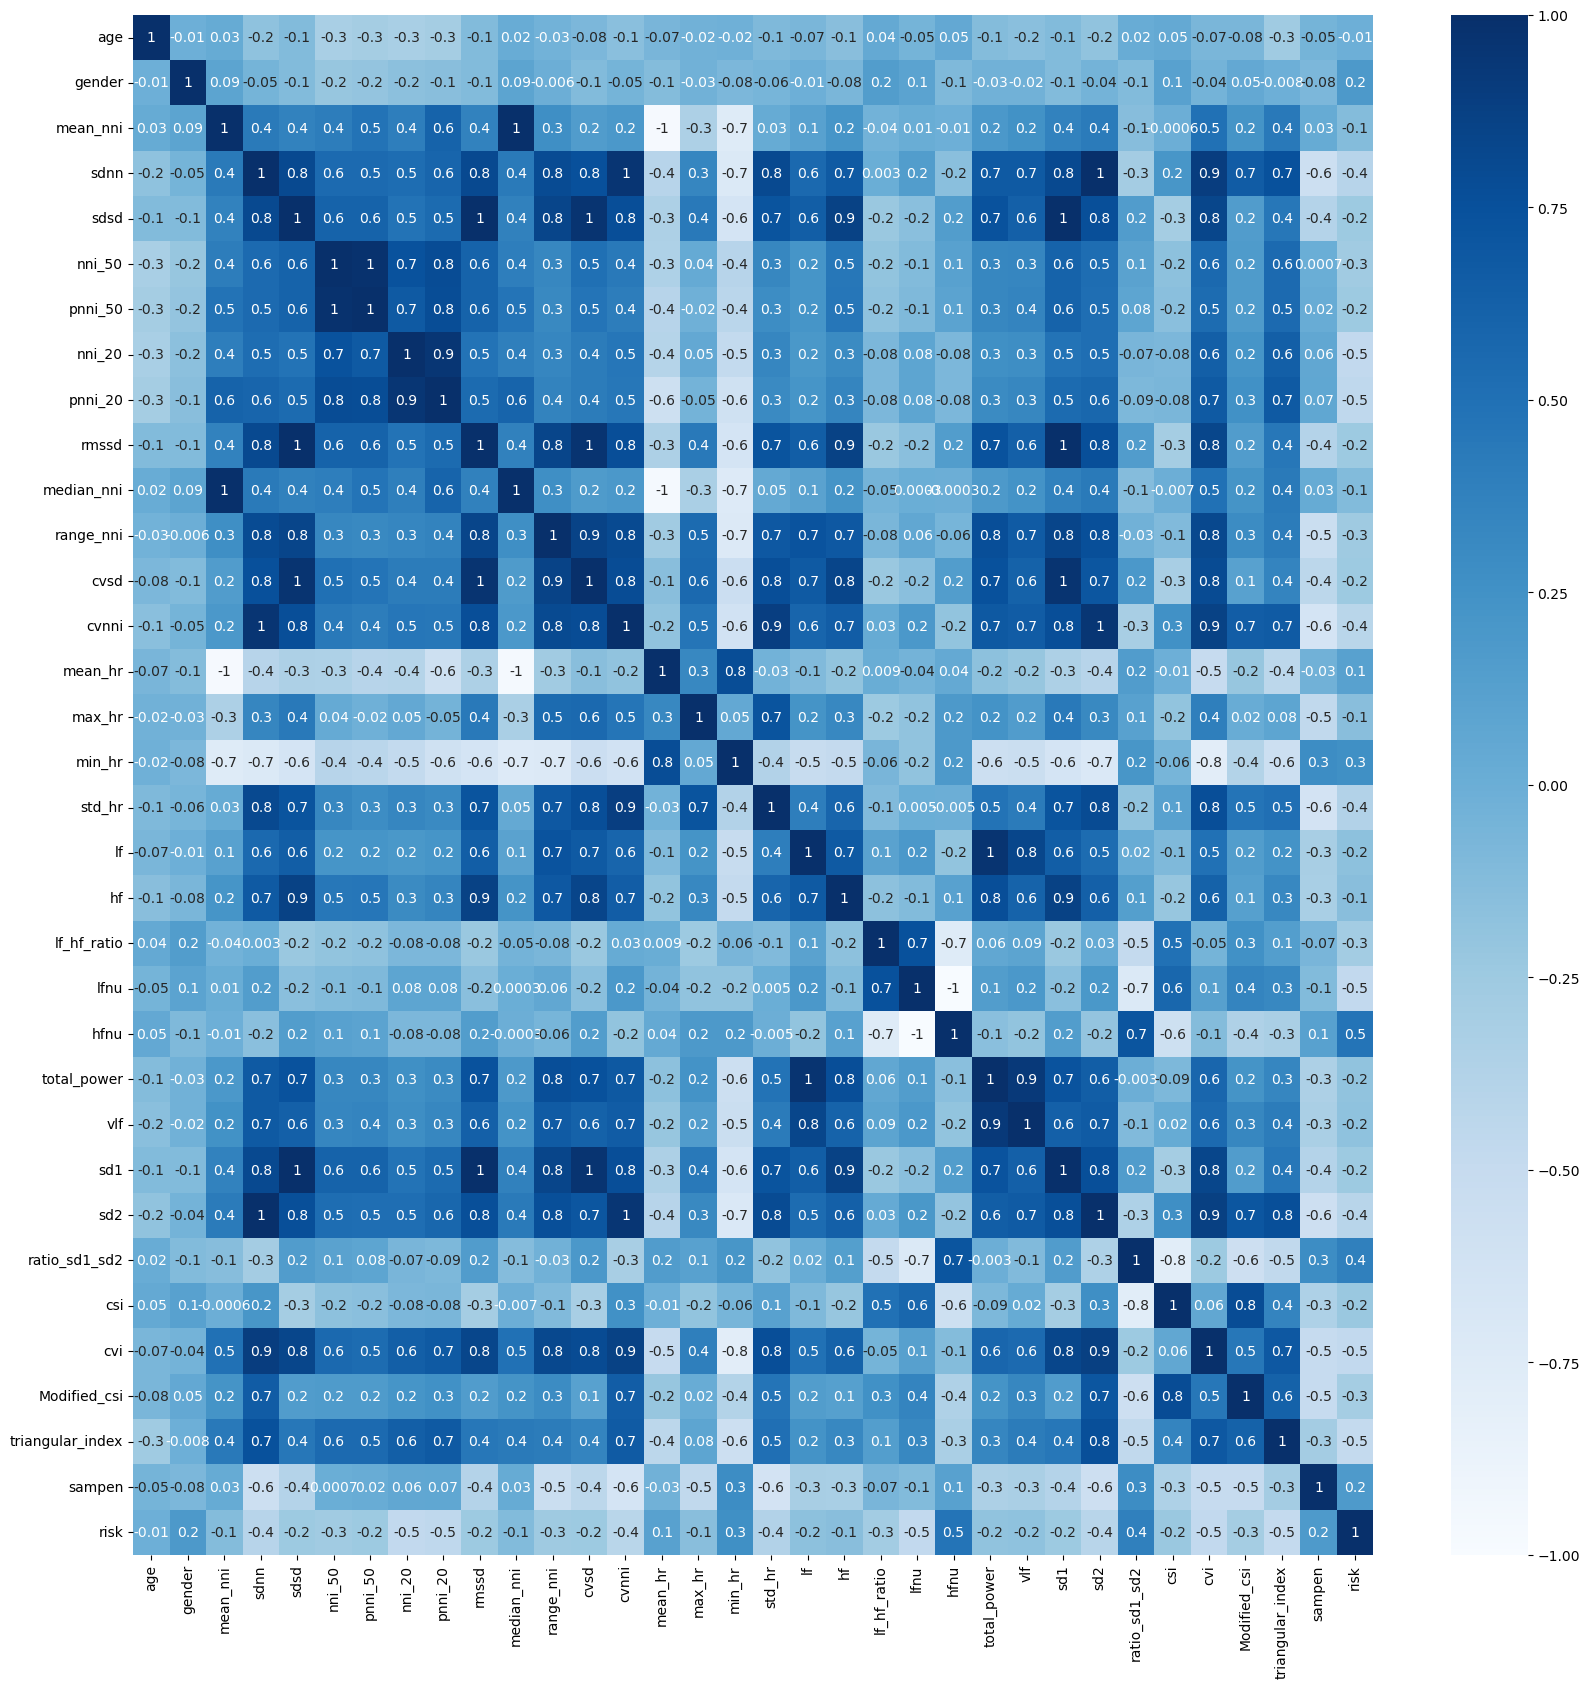

In [18]:
plt.rcParams['figure.figsize'] = (20, 20)
heatmap = sns.heatmap(df_train.corr(), annot=True, cmap="Blues", fmt='.1g')
plt.rcdefaults()
plt.show()

## XGBoost

In [19]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut

from sklearn.metrics import make_scorer

In [20]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

In [21]:
# A parameter grid for XGBoost
params = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 5, 10],
    'gamma': [1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [22]:
gs = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [23]:
start = datetime.datetime.now()
gs.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 33)
Fitting time: 0 hours, 10 minutes, 15 seconds, 397198 microseconds


## Evaluation

In [24]:
gs.score(X_test, y_test)

0.9624119028974158

TRAIN SET RESULTS
TN, FP, FN, TP       : 2324 2 0 787
Accuracy (Train)     : 0.9993575329264375
Precision (Train)    : 0.9993591614868268
Sensitivity (Train)  : 1.0
Specificity (Train)  : 0.999140154772141
F1-Score (Train)     : 0.999357802418248
AUC Score (Train)    : 0.9995700773860705
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




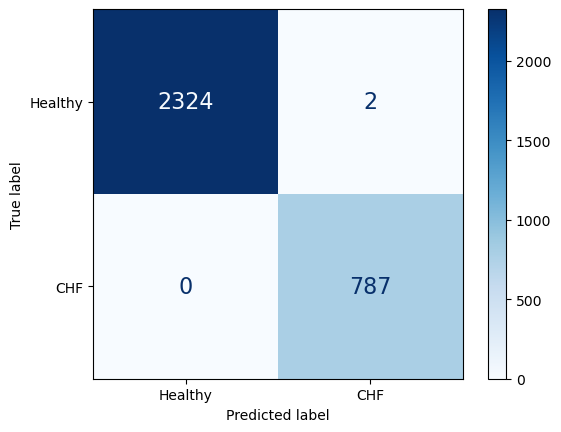


TEST SET RESULTS
TN, FP, FN, TP       : 940 31 17 289
Accuracy             : 0.9624119028974158
Precision            : 0.963279213911589
Sensitivity          : 0.9444444444444444
Specificity          : 0.9680741503604532
F1-Score             : 0.9626957457753613
AUC Score            : 0.9562592974024489
              precision    recall  f1-score   support

     Healthy       0.98      0.97      0.98       971
         CHF       0.90      0.94      0.92       306

    accuracy                           0.96      1277
   macro avg       0.94      0.96      0.95      1277
weighted avg       0.96      0.96      0.96      1277




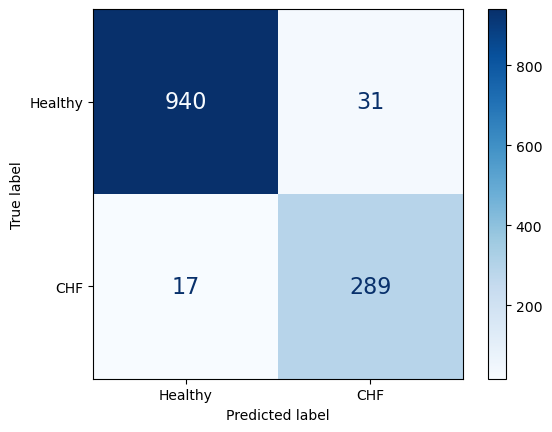

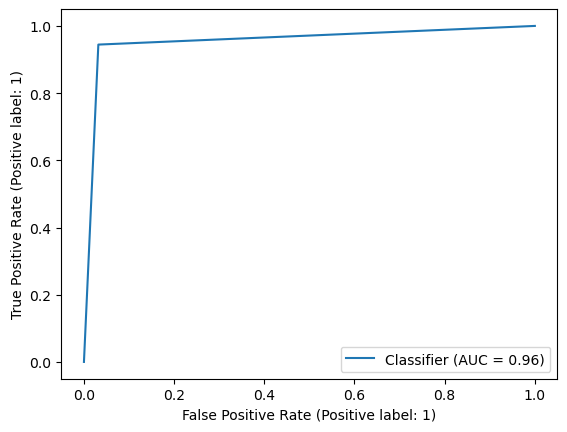

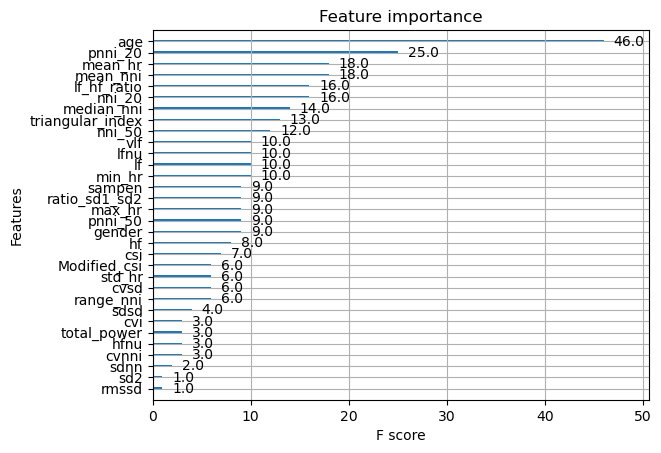

In [25]:
y_pred_train = gs.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs.best_estimator_)
plt.show()

In [26]:
print("Best Params")
pprint.pprint(gs.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 150,
 'subsample': 0.6}



### Sensitivity

In [27]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall",
)

In [28]:
start = datetime.datetime.now()
gs_sensitivity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 33)
Fitting time: 0 hours, 10 minutes, 20 seconds, 97216 microseconds


In [29]:
gs_sensitivity.score(X_test, y_test)

0.9411764705882353

TRAIN SET RESULTS
TN, FP, FN, TP       : 2324 2 1 786
Accuracy (Train)     : 0.9990362993896563
Precision (Train)    : 0.9990369765382393
Sensitivity (Train)  : 0.9987293519695044
Specificity (Train)  : 0.999140154772141
F1-Score (Train)     : 0.9990365017249163
AUC Score (Train)    : 0.9989347533708227
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




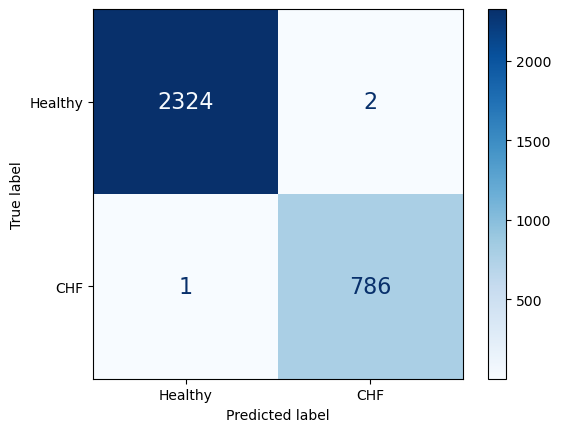


TEST SET RESULTS
TN, FP, FN, TP       : 942 29 18 288
Accuracy             : 0.9631949882537196
Precision            : 0.9638215028569028
Sensitivity          : 0.9411764705882353
Specificity          : 0.9701338825952626
F1-Score             : 0.9634150816812244
AUC Score            : 0.9556551765917489
              precision    recall  f1-score   support

     Healthy       0.98      0.97      0.98       971
         CHF       0.91      0.94      0.92       306

    accuracy                           0.96      1277
   macro avg       0.94      0.96      0.95      1277
weighted avg       0.96      0.96      0.96      1277




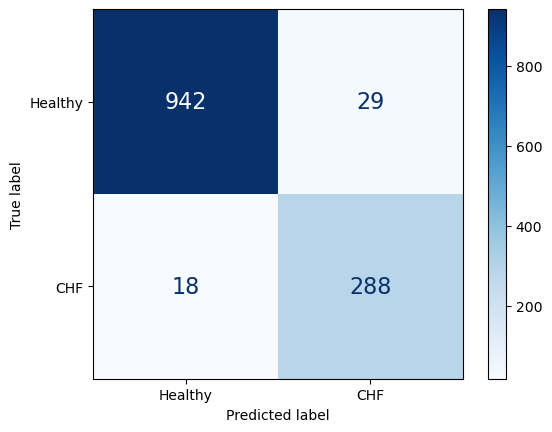

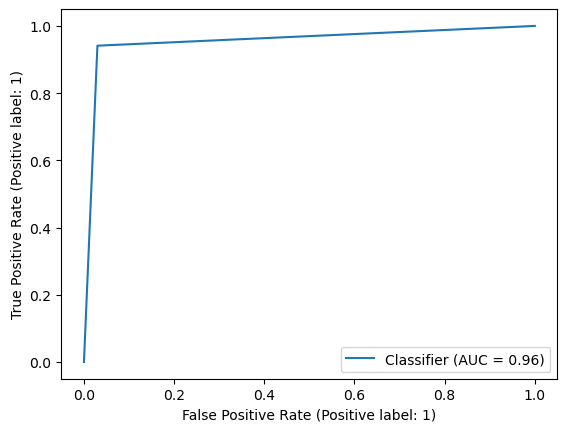

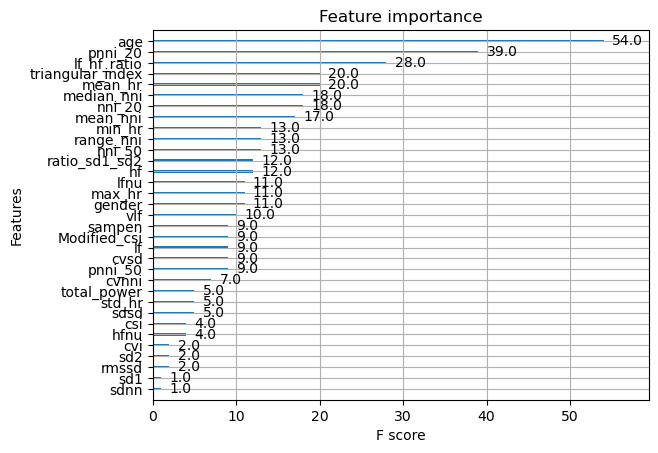

In [30]:
y_pred_train = gs_sensitivity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_sensitivity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity.best_estimator_)
plt.show()

In [31]:
print("Best Params")
pprint.pprint(gs_sensitivity.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.6}



### Specificity

In [32]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

specificity = make_scorer(recall_score, pos_label=0)

gs_specificity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring=specificity,
)

In [33]:
start = datetime.datetime.now()
gs_specificity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 33)
Fitting time: 0 hours, 10 minutes, 20 seconds, 814075 microseconds


In [34]:
gs_specificity.score(X_test, y_test)

0.96086508753862

TRAIN SET RESULTS
TN, FP, FN, TP       : 2326 0 0 787
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




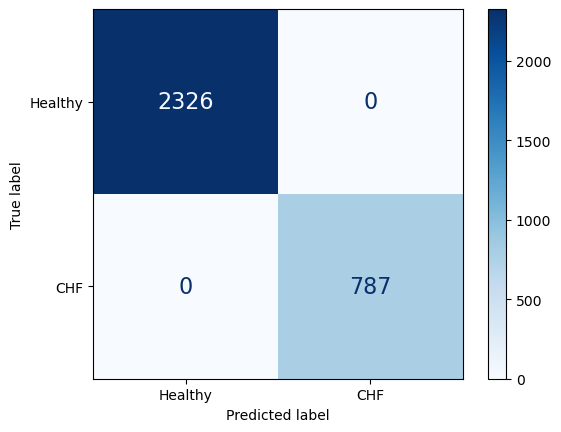


TEST SET RESULTS
TN, FP, FN, TP       : 933 38 24 282
Accuracy             : 0.9514487079091621
Precision            : 0.9524756482547506
Sensitivity          : 0.9215686274509803
Specificity          : 0.96086508753862
F1-Score             : 0.951815338293175
AUC Score            : 0.9412168574948001
              precision    recall  f1-score   support

     Healthy       0.97      0.96      0.97       971
         CHF       0.88      0.92      0.90       306

    accuracy                           0.95      1277
   macro avg       0.93      0.94      0.93      1277
weighted avg       0.95      0.95      0.95      1277




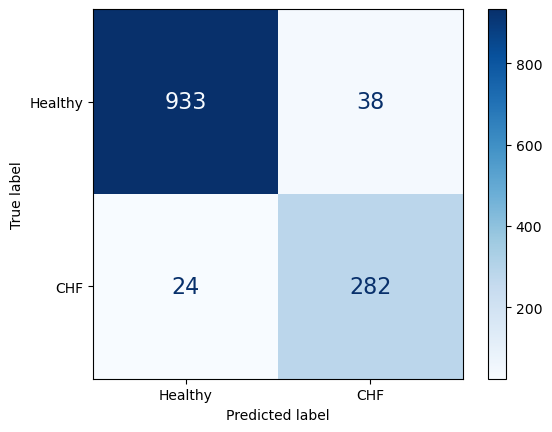

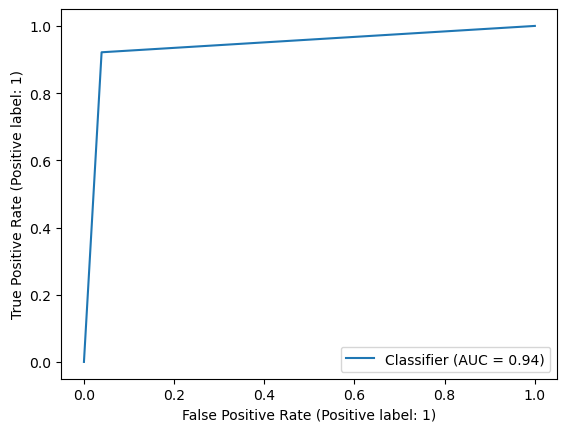

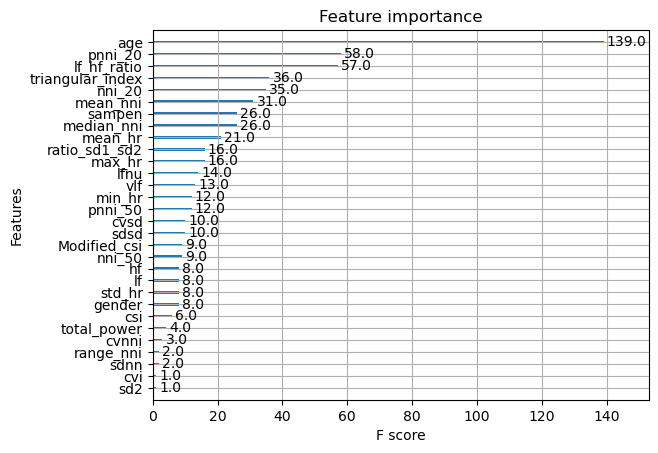

In [35]:
y_pred_train = gs_specificity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_specificity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_specificity.best_estimator_)
plt.show()

In [36]:
print("Best Params")
pprint.pprint(gs_specificity.best_params_)
print()

Best Params
{'colsample_bytree': 0.8,
 'gamma': 1,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 1.0}



## Save model

In [37]:
import pickle
# Ref: https://stackoverflow.com/questions/57730192/how-to-save-gridsearchcv-xgboost-model

# Dictionary of best parameters
best_pars = gs.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = gs.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))

In [38]:
# Ref: https://stackoverflow.com/a/64823806

import joblib

#save your model or results
gs_filename = f"xgb-gs-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs, os.path.join(MODEL_DIR, gs_filename))

#load your model for further usage
gs_best = joblib.load(os.path.join(MODEL_DIR, gs_filename))


In [39]:
gs_best.best_estimator_.score(X_test, y_test), gs_best.best_params_

(0.9624119028974158,
 {'colsample_bytree': 0.6,
  'gamma': 1,
  'learning_rate': 0.4,
  'max_depth': 6,
  'min_child_weight': 5,
  'n_estimators': 150,
  'subsample': 0.6})

### Sensitivity

In [40]:
import pickle

# Best XGB model that was found based on the metric score you specify
best_model = gs_sensitivity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-sensitivity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_sensitivity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_sensitivity_filename = f"xgb-gs_sensitivity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_sensitivity, os.path.join(MODEL_DIR, gs_sensitivity_filename))

#load your model for further usage
gs_sensitivity_best = joblib.load(os.path.join(MODEL_DIR, gs_sensitivity_filename))
print(gs_sensitivity_best.best_params_)

{'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}


### Specificity

In [41]:
import pickle
import joblib

# Best XGB model that was found based on the metric score you specify
best_model = gs_specificity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-specificity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_specificity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_specificity_filename = f"xgb-gs_specificity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_specificity, os.path.join(MODEL_DIR, gs_specificity_filename))

#load your model for further usage
gs_specificity_best = joblib.load(os.path.join(MODEL_DIR, gs_specificity_filename))
print(gs_specificity_best.best_params_)

{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}


## Feature Selection

In [42]:
# ref: https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
importance_score = gs.best_estimator_.get_booster().get_score(importance_type='weight')
top_importance_score = {k: v for k, v in sorted(importance_score.items(), key=lambda item: item[1], reverse=True)}

top_5_features = []
top_10_features = []
top_15_features = []
for k, v in top_importance_score.items():
    if len(top_5_features) < 5:
        top_5_features.append(k)
    if len(top_10_features) < 10:
        top_10_features.append(k)
    if len(top_15_features) < 15:
        top_15_features.append(k)

### ReFit - Top 5

In [43]:
X_top_5_train = X_train[top_5_features]
X_top_5_test = X_test[top_5_features]

print(X_top_5_train.shape, y_train.shape)
print(X_top_5_test.shape, y_test.shape)

(3113, 5) (3113,)
(1277, 5) (1277,)


In [44]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_5 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [45]:
start = datetime.datetime.now()
gs_sensitivity_top_5.fit(X_top_5_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_5_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 5)
Fitting time: 0 hours, 3 minutes, 25 seconds, 981839 microseconds


In [46]:
gs_sensitivity_top_5.score(X_top_5_test, y_test)

0.738562091503268

TRAIN SET RESULTS
TN, FP, FN, TP       : 2323 3 2 785
Accuracy (Train)     : 0.9983938323160938
Precision (Train)    : 0.9983947789564874
Sensitivity (Train)  : 0.9974587039390089
Specificity (Train)  : 0.9987102321582115
F1-Score (Train)     : 0.9983941695415272
AUC Score (Train)    : 0.9980844680486102
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




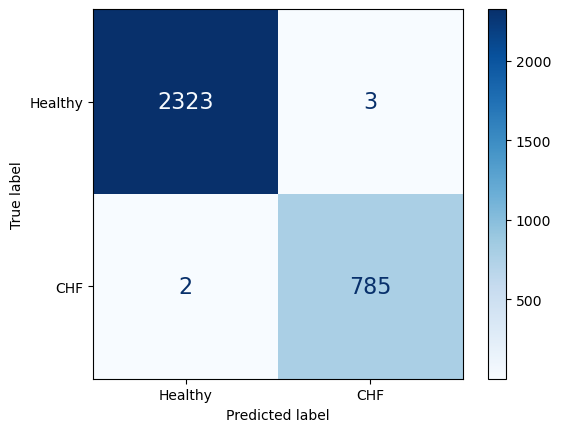


TEST SET RESULTS
TN, FP, FN, TP       : 886 85 80 226
Accuracy             : 0.8707909162098669
Precision            : 0.8715367899847943
Sensitivity          : 0.738562091503268
Specificity          : 0.9124613800205973
F1-Score             : 0.8711476893920986
AUC Score            : 0.8255117357619326
              precision    recall  f1-score   support

     Healthy       0.92      0.91      0.91       971
         CHF       0.73      0.74      0.73       306

    accuracy                           0.87      1277
   macro avg       0.82      0.83      0.82      1277
weighted avg       0.87      0.87      0.87      1277




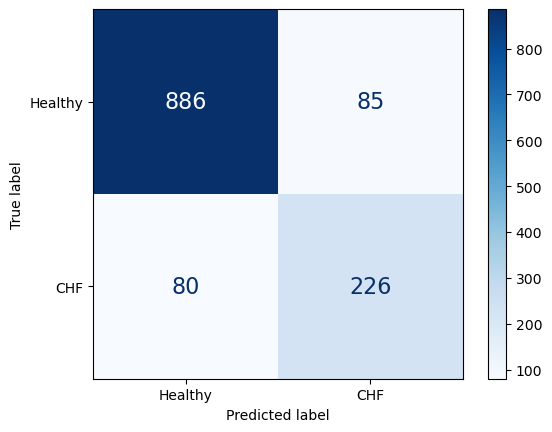

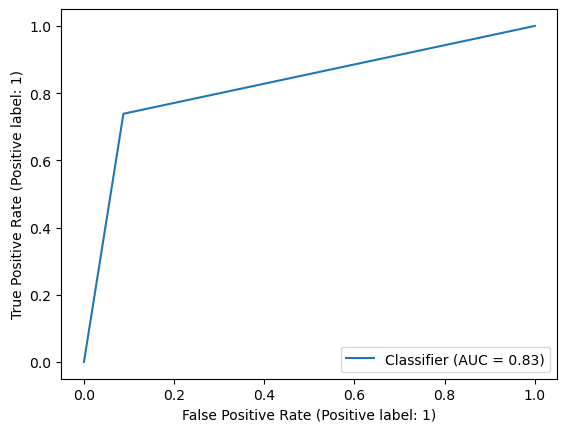

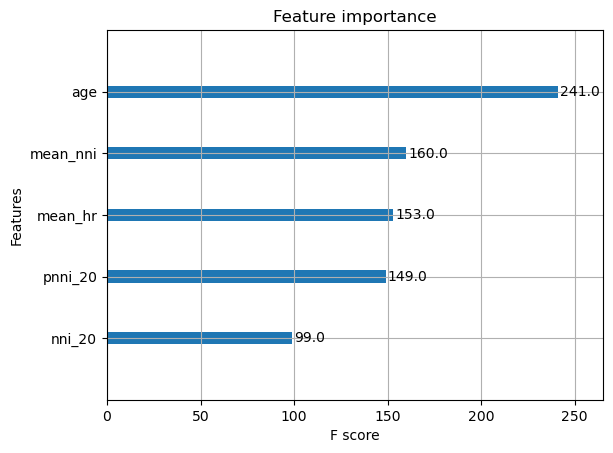

In [47]:
y_pred_train = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_5.best_estimator_)
plt.show()

### ReFit - Top 10

In [48]:
X_top_10_train = X_train[top_10_features]
X_top_10_test = X_test[top_10_features]

print(X_top_10_train.shape, y_train.shape)
print(X_top_10_test.shape, y_test.shape)

(3113, 10) (3113,)
(1277, 10) (1277,)


In [49]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_10 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [50]:
start = datetime.datetime.now()
gs_sensitivity_top_10.fit(X_top_10_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_10_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 10)
Fitting time: 0 hours, 4 minutes, 3 seconds, 875347 microseconds


In [51]:
gs_sensitivity_top_10.score(X_top_10_test, y_test)

0.9342208300704777

TRAIN SET RESULTS
TN, FP, FN, TP       : 2326 0 0 787
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




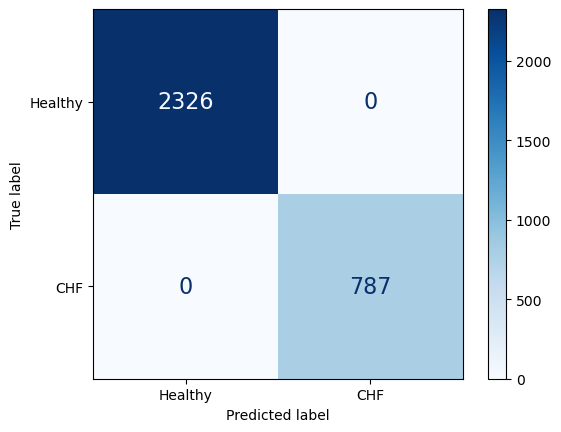


TEST SET RESULTS
TN, FP, FN, TP       : 907 64 20 286
Accuracy             : 0.9342208300704777
Precision            : 0.9397779291091133
Sensitivity          : 0.934640522875817
Specificity          : 0.9340885684860968
F1-Score             : 0.9356643826861597
AUC Score            : 0.934364545680957
              precision    recall  f1-score   support

     Healthy       0.98      0.93      0.96       971
         CHF       0.82      0.93      0.87       306

    accuracy                           0.93      1277
   macro avg       0.90      0.93      0.91      1277
weighted avg       0.94      0.93      0.94      1277




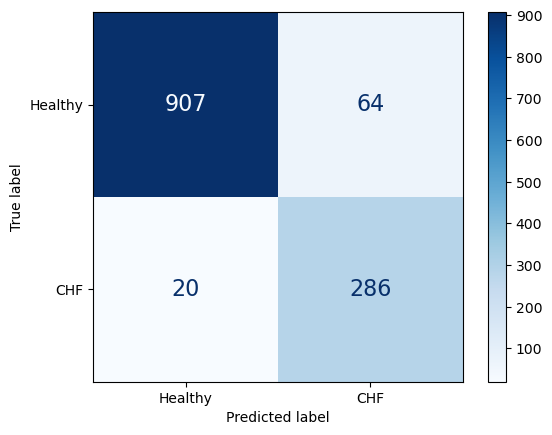

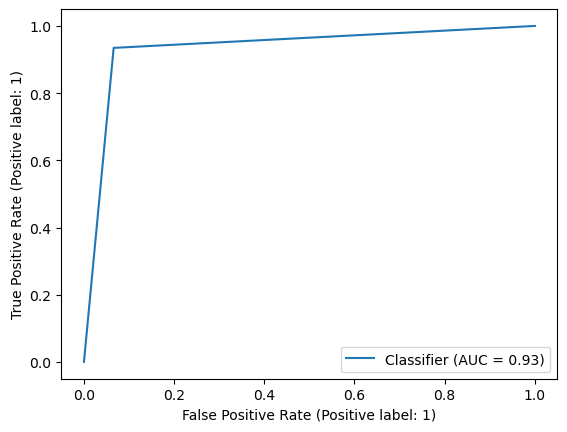

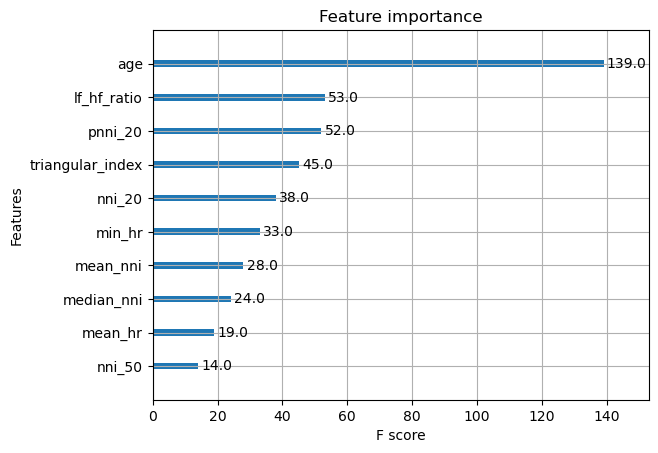

In [52]:
y_pred_train = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_10.best_estimator_)
plt.show()

### ReFit - Top 15

In [53]:
X_top_15_train = X_train[top_15_features]
X_top_15_test = X_test[top_15_features]

print(X_top_15_train.shape, y_train.shape)
print(X_top_15_test.shape, y_test.shape)

(3113, 15) (3113,)
(1277, 15) (1277,)


In [54]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_15 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [55]:
start = datetime.datetime.now()
gs_sensitivity_top_15.fit(X_top_15_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_15_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 15)
Fitting time: 0 hours, 5 minutes, 16 seconds, 529194 microseconds


In [56]:
gs_sensitivity_top_15.score(X_top_15_test, y_test)

0.9725920125293657

TRAIN SET RESULTS
TN, FP, FN, TP       : 2320 6 7 780
Accuracy (Train)     : 0.9958239640218439
Precision (Train)    : 0.9958224781809294
Sensitivity (Train)  : 0.9911054637865311
Specificity (Train)  : 0.9974204643164231
F1-Score (Train)     : 0.9958230853571475
AUC Score (Train)    : 0.9942629640514771
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       0.99      0.99      0.99       787

    accuracy                           1.00      3113
   macro avg       0.99      0.99      0.99      3113
weighted avg       1.00      1.00      1.00      3113




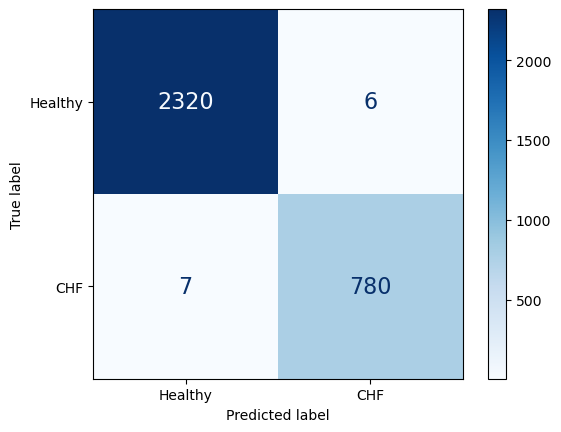


TEST SET RESULTS
TN, FP, FN, TP       : 937 34 1 305
Accuracy             : 0.9725920125293657
Precision            : 0.9751562672487083
Sensitivity          : 0.9967320261437909
Specificity          : 0.964984552008239
F1-Score             : 0.9730562524915909
AUC Score            : 0.9808582890760149
              precision    recall  f1-score   support

     Healthy       1.00      0.96      0.98       971
         CHF       0.90      1.00      0.95       306

    accuracy                           0.97      1277
   macro avg       0.95      0.98      0.96      1277
weighted avg       0.98      0.97      0.97      1277




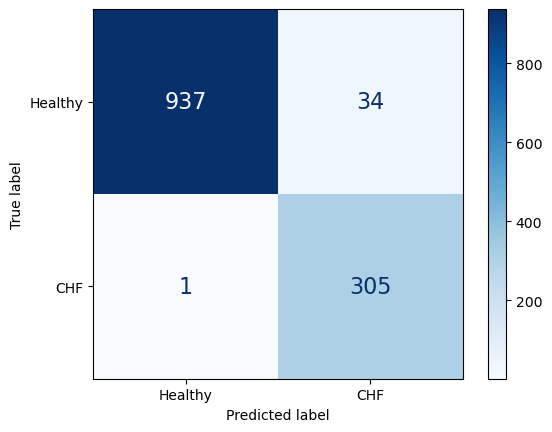

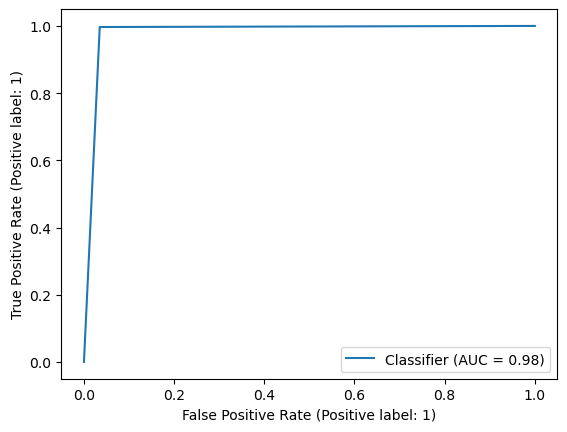

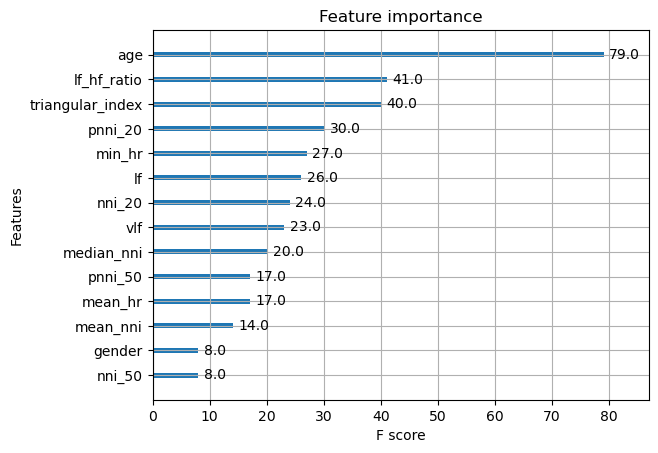

In [57]:
y_pred_train = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_15.best_estimator_)
plt.show()

## Feature Reduction

### Remove Age

In [58]:
columns_wo_age = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_age.remove("age")

In [59]:
X_wo_age_train = X_train[columns_wo_age]
X_wo_age_test = X_test[columns_wo_age]

print(X_wo_age_train.shape, y_train.shape)
print(X_wo_age_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_age_train.sample(3))
pd.reset_option("display.max_columns")

(3113, 30) (3113,)
(1277, 30) (1277,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
2519,0,518.747297,25.594193,16.880911,5,0.866551,110,19.064125,16.881107,515.6250,195.3125,0.032542,0.049338,115.938672,139.636364,96.000000,5.604990,211.976442,41.354754,5.125806,83.675617,16.324383,418.369052,165.037857,11.946964,34.167170,0.349662,2.859904,3.814987,390.859293
2154,0,636.786099,40.480822,14.029126,1,0.432900,39,16.883117,14.039559,625.0000,187.5000,0.022048,0.063571,94.584062,105.205479,79.175258,5.700654,88.334509,10.337076,8.545406,89.523756,10.476244,444.281629,345.610045,9.941632,56.378700,0.176337,5.670970,3.952693,1278.887658
3501,0,683.750392,94.615132,36.409750,12,3.015075,100,25.125628,36.412549,632.8125,539.0625,0.053254,0.138377,89.642132,192.000000,70.458716,14.616634,351.059310,375.020764,0.936106,48.349944,51.650056,1354.119799,628.039725,25.777986,131.299436,0.196330,5.093471,4.733632,2675.079705


In [60]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_age = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)


In [61]:
start = datetime.datetime.now()
gs_sensitivity_wo_age.fit(X_wo_age_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_age_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 30)
Fitting time: 0 hours, 12 minutes, 2 seconds, 169486 microseconds


In [62]:
gs_sensitivity_wo_age.score(X_wo_age_test, y_test)

0.869281045751634

TRAIN SET RESULTS
TN, FP, FN, TP       : 2322 4 10 777
Accuracy (Train)     : 0.9955027304850627
Precision (Train)    : 0.9955011240457585
Sensitivity (Train)  : 0.9872935196950444
Specificity (Train)  : 0.998280309544282
F1-Score (Train)     : 0.9954970224963375
AUC Score (Train)    : 0.9927869146196633
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       0.99      0.99      0.99       787

    accuracy                           1.00      3113
   macro avg       1.00      0.99      0.99      3113
weighted avg       1.00      1.00      1.00      3113




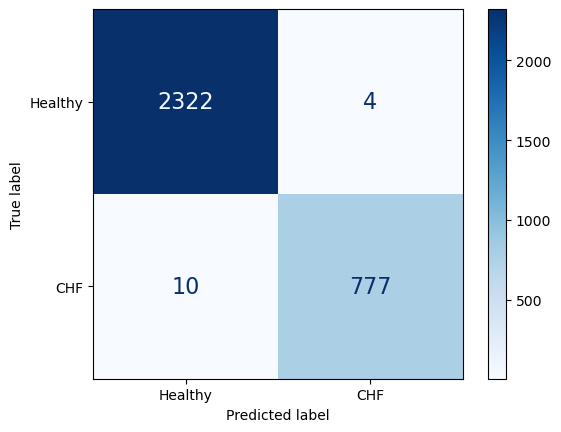


TEST SET RESULTS
TN, FP, FN, TP       : 925 46 40 266
Accuracy             : 0.93265465935787
Precision            : 0.9331526317317173
Sensitivity          : 0.869281045751634
Specificity          : 0.952626158599382
F1-Score             : 0.9328772210378584
AUC Score            : 0.910953602175508
              precision    recall  f1-score   support

     Healthy       0.96      0.95      0.96       971
         CHF       0.85      0.87      0.86       306

    accuracy                           0.93      1277
   macro avg       0.91      0.91      0.91      1277
weighted avg       0.93      0.93      0.93      1277




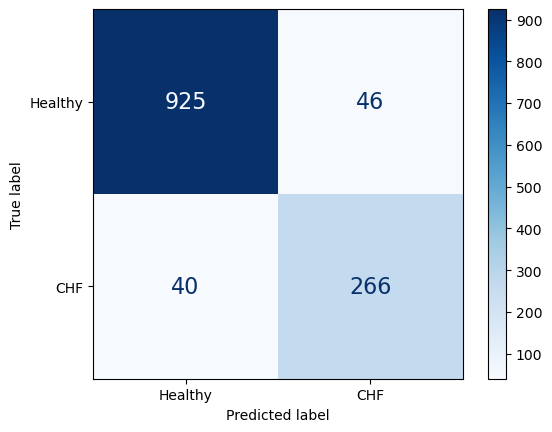

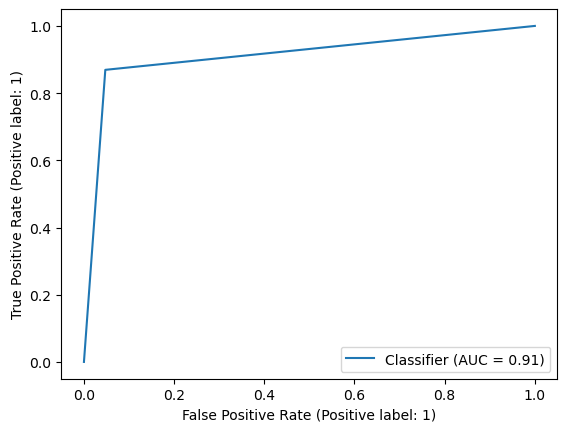

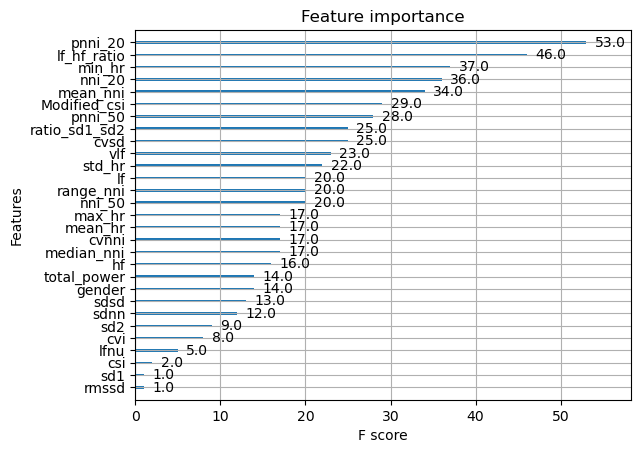

In [63]:
y_pred_train = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_age.best_estimator_)
plt.show()

### Remove LF/HF

In [64]:
columns_wo_lf_hf_ratio = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_lf_hf_ratio.remove("lf_hf_ratio")

In [65]:
X_wo_lf_hf_ratio_train = X_train[columns_wo_lf_hf_ratio]
X_wo_lf_hf_ratio_test = X_test[columns_wo_lf_hf_ratio]

print(X_wo_lf_hf_ratio_train.shape, y_train.shape)
print(X_wo_lf_hf_ratio_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_lf_hf_ratio_train.sample(3))
pd.reset_option("display.max_columns")

(3113, 30) (3113,)
(1277, 30) (1277,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
3490,64.0,0,892.863806,36.208647,28.596519,21,6.287425,160,47.904192,28.596529,898.4375,195.3125,0.032028,0.040553,67.312882,77.575758,61.935484,2.804497,453.211258,237.470526,65.617954,34.382046,840.849234,150.167450,20.251131,47.032159,0.430581,2.322446,4.182964,436.918594
882,71.0,1,821.175824,28.761427,13.694288,0,0.000000,34,9.366391,13.694824,824.0000,148.0000,0.016677,0.035025,73.155298,79.365079,66.371681,2.557304,36.345481,20.558527,63.871566,36.128434,222.768642,165.864634,9.696689,39.502071,0.245473,4.073769,3.787363,643.689224
352,32.0,0,777.832031,66.680160,33.402230,48,12.532637,195,50.913838,33.404248,773.4375,351.5625,0.042945,0.085726,77.708087,94.814815,60.952381,6.700256,899.607233,382.179045,70.183871,29.816129,2293.797988,1012.011710,23.649838,91.286214,0.259073,3.859909,4.538353,1409.425776


In [66]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_lf_hf_ratio = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [67]:
start = datetime.datetime.now()
gs_sensitivity_wo_lf_hf_ratio.fit(X_wo_lf_hf_ratio_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_lf_hf_ratio_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 30)
Fitting time: 0 hours, 9 minutes, 38 seconds, 490900 microseconds


In [68]:
gs_sensitivity_wo_lf_hf_ratio.score(X_wo_lf_hf_ratio_test, y_test)

0.954248366013072

TRAIN SET RESULTS
TN, FP, FN, TP       : 2323 3 1 786
Accuracy (Train)     : 0.9987150658528751
Precision (Train)    : 0.9987172322446319
Sensitivity (Train)  : 0.9987293519695044
Specificity (Train)  : 0.9987102321582115
F1-Score (Train)     : 0.9987156048364959
AUC Score (Train)    : 0.998719792063858
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      1.00      1.00       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




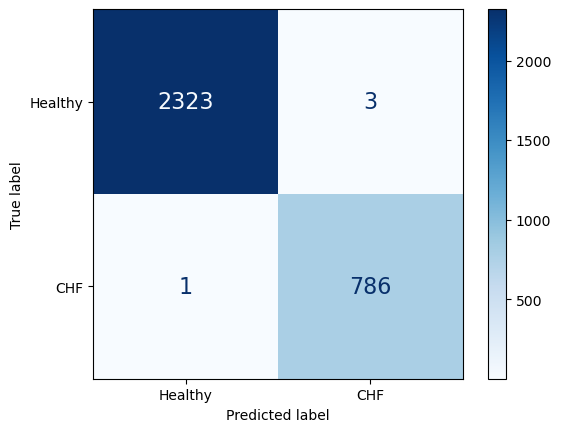


TEST SET RESULTS
TN, FP, FN, TP       : 942 29 14 292
Accuracy             : 0.966327329678935
Precision            : 0.9672165034572822
Sensitivity          : 0.954248366013072
Specificity          : 0.9701338825952626
F1-Score             : 0.9665990567568569
AUC Score            : 0.9621911243041673
              precision    recall  f1-score   support

     Healthy       0.99      0.97      0.98       971
         CHF       0.91      0.95      0.93       306

    accuracy                           0.97      1277
   macro avg       0.95      0.96      0.95      1277
weighted avg       0.97      0.97      0.97      1277




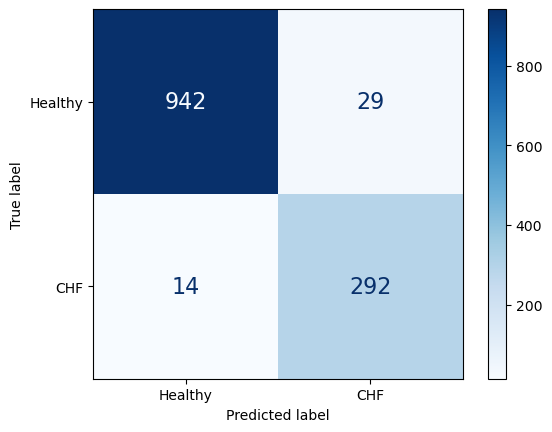

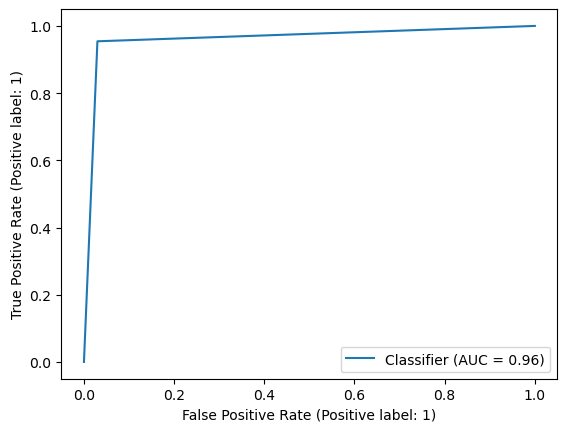

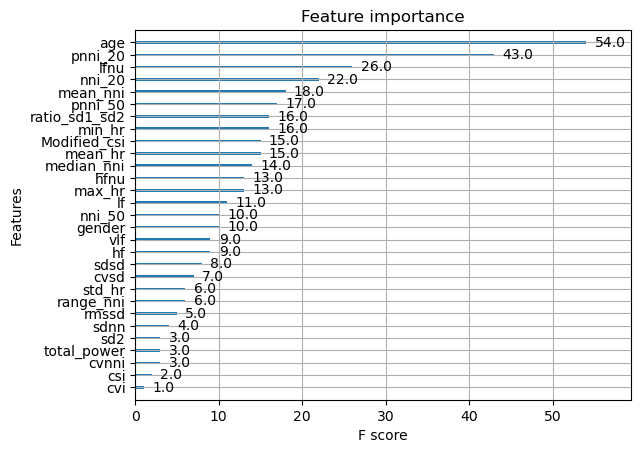

In [69]:
y_pred_train = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_lf_hf_ratio.best_estimator_)
plt.show()

### Remove NNI_20

In [70]:
columns_wo_nni_20 = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_nni_20.remove("nni_20")

In [71]:
X_wo_nni_20_train = X_train[columns_wo_nni_20]
X_wo_nni_20_test = X_test[columns_wo_nni_20]

print(X_wo_nni_20_train.shape, y_train.shape)
print(X_wo_nni_20_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_nni_20_train.sample(3))
pd.reset_option("display.max_columns")

(3113, 30) (3113,)
(1277, 30) (1277,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
453,45.0,0,915.495986,163.689476,102.461087,141,43.251534,70.552147,102.461804,914.0625,953.1250,0.111919,0.178799,68.122189,170.666667,45.988024,15.895875,3284.462992,2131.775490,1.540717,60.641033,39.358967,11360.076324,5943.837842,72.562307,219.825387,0.330091,3.029471,5.406909,2663.818349
2241,65.0,0,702.189701,52.593708,29.018534,26,6.117647,29.411765,29.019675,695.3125,273.4375,0.041327,0.074900,85.910059,97.215190,67.368421,6.215447,173.675873,90.491440,1.919252,65.744649,34.255351,1035.538098,771.370786,20.543385,71.485422,0.287379,3.479729,4.371009,994.999711
1662,67.0,1,747.553662,65.773138,14.254564,0,0.000000,14.430380,14.254578,757.8125,257.8125,0.019068,0.087985,80.903676,96.000000,67.964602,7.328757,332.308308,16.708556,19.888511,95.212679,4.787321,1110.671396,761.654531,10.092282,92.468142,0.109143,9.162263,4.174101,3388.869705


In [72]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_nni_20 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [73]:
start = datetime.datetime.now()
gs_sensitivity_wo_nni_20.fit(X_wo_nni_20_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_nni_20_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 30)
Fitting time: 0 hours, 9 minutes, 46 seconds, 23232 microseconds


In [74]:
gs_sensitivity_wo_nni_20.score(X_wo_nni_20_test, y_test)

0.9607843137254902

TRAIN SET RESULTS
TN, FP, FN, TP       : 2322 4 6 781
Accuracy (Train)     : 0.9967876646321876
Precision (Train)    : 0.9967860467575883
Sensitivity (Train)  : 0.9923761118170267
Specificity (Train)  : 0.998280309544282
F1-Score (Train)     : 0.996786311392915
AUC Score (Train)    : 0.9953282106806544
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       0.99      0.99      0.99       787

    accuracy                           1.00      3113
   macro avg       1.00      1.00      1.00      3113
weighted avg       1.00      1.00      1.00      3113




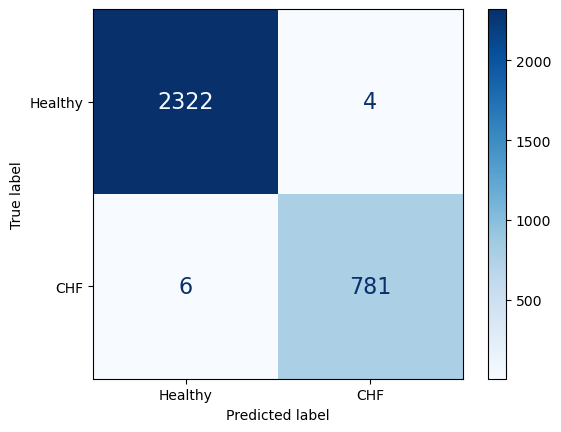


TEST SET RESULTS
TN, FP, FN, TP       : 942 29 12 294
Accuracy             : 0.9678935003915426
Precision            : 0.9689212837208192
Sensitivity          : 0.9607843137254902
Specificity          : 0.9701338825952626
F1-Score             : 0.968185603048563
AUC Score            : 0.9654590981603763
              precision    recall  f1-score   support

     Healthy       0.99      0.97      0.98       971
         CHF       0.91      0.96      0.93       306

    accuracy                           0.97      1277
   macro avg       0.95      0.97      0.96      1277
weighted avg       0.97      0.97      0.97      1277




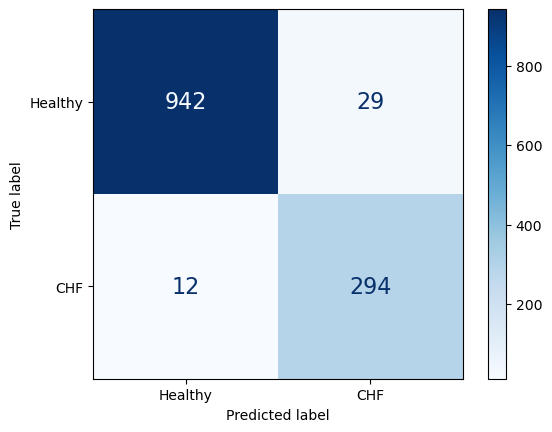

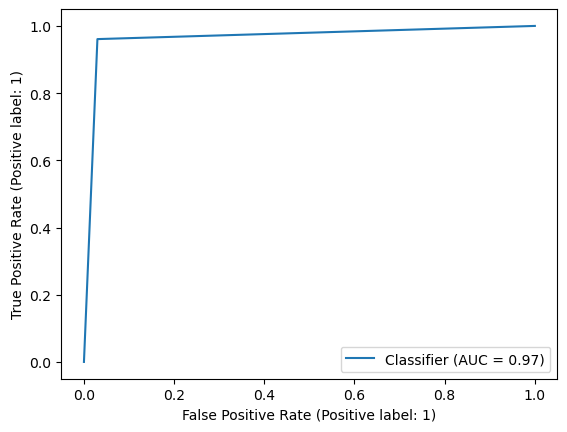

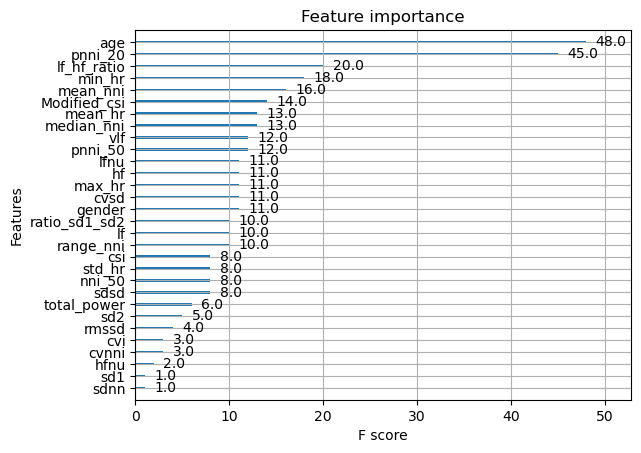

In [75]:
y_pred_train = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_nni_20.best_estimator_)
plt.show()

### Remove Age, LF/HF, NNI_20

In [76]:
columns_wo_all = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_all.remove("age")
columns_wo_all.remove("lf_hf_ratio")
columns_wo_all.remove("nni_20")

In [77]:
X_wo_all_train = X_train[columns_wo_all]
X_wo_all_test = X_test[columns_wo_all]

print(X_wo_all_train.shape, y_train.shape)
print(X_wo_all_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_all_train.sample(3))
pd.reset_option("display.max_columns")

(3113, 28) (3113,)
(1277, 28) (1277,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
1898,1,689.318116,19.871975,14.375127,0,0.000000,17.551963,14.375173,695.31250,109.375,0.020854,0.028828,87.115313,94.814815,80.842105,2.528764,72.868235,13.207886,84.655575,15.344425,171.121883,85.045762,10.176508,26.195982,0.388476,2.574162,3.629953,269.730832
407,0,679.739583,230.990296,53.828827,68,15.144766,44.543430,53.831358,628.90625,843.750,0.079194,0.339822,99.104559,196.923077,52.244898,33.316286,1847.340469,896.012975,67.338770,32.661230,5559.312140,2815.958696,38.105186,324.439561,0.117449,8.514315,5.296238,11049.522743
981,1,812.529030,84.502125,79.581919,28,7.671233,11.506849,79.582067,816.00000,1006.000,0.097944,0.103999,74.778808,152.284264,42.857143,9.860512,3788.085098,1847.090257,67.222133,32.777867,6935.676065,1300.500710,56.350160,105.384428,0.534710,1.870171,4.977792,788.347564


In [78]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_all = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [79]:
start = datetime.datetime.now()
gs_sensitivity_wo_all.fit(X_wo_all_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_all_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (3113, 28)
Fitting time: 0 hours, 11 minutes, 24 seconds, 852910 microseconds


In [80]:
gs_sensitivity_wo_all.score(X_wo_all_test, y_test)

0.8496732026143791

TRAIN SET RESULTS
TN, FP, FN, TP       : 2323 3 10 777
Accuracy (Train)     : 0.9958239640218439
Precision (Train)    : 0.9958249538096382
Sensitivity (Train)  : 0.9872935196950444
Specificity (Train)  : 0.9987102321582115
F1-Score (Train)     : 0.9958177737452543
AUC Score (Train)    : 0.993001875926628
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      2326
         CHF       1.00      0.99      0.99       787

    accuracy                           1.00      3113
   macro avg       1.00      0.99      0.99      3113
weighted avg       1.00      1.00      1.00      3113




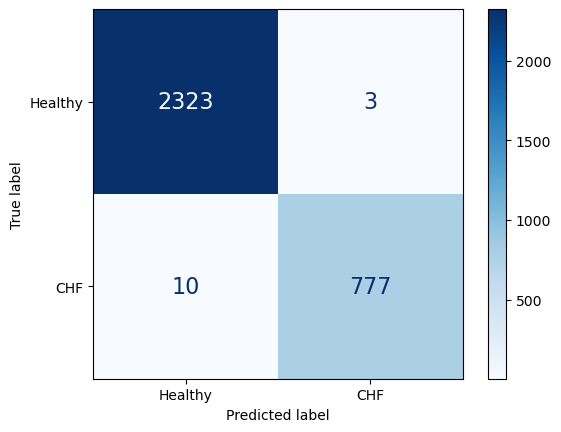


TEST SET RESULTS
TN, FP, FN, TP       : 927 44 46 260
Accuracy             : 0.9295223179326546
Precision            : 0.9293696783436765
Sensitivity          : 0.8496732026143791
Specificity          : 0.9546858908341915
F1-Score             : 0.9294430347006184
AUC Score            : 0.9021795467242854
              precision    recall  f1-score   support

     Healthy       0.95      0.95      0.95       971
         CHF       0.86      0.85      0.85       306

    accuracy                           0.93      1277
   macro avg       0.90      0.90      0.90      1277
weighted avg       0.93      0.93      0.93      1277




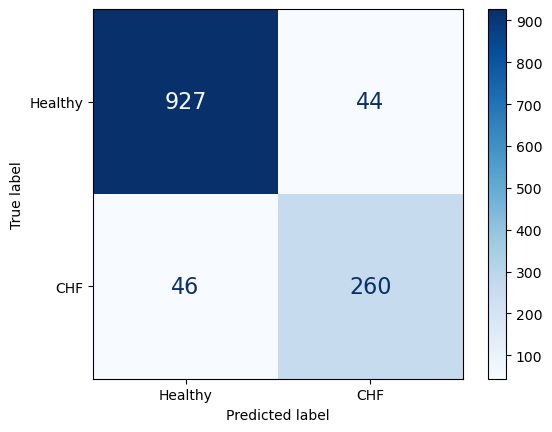

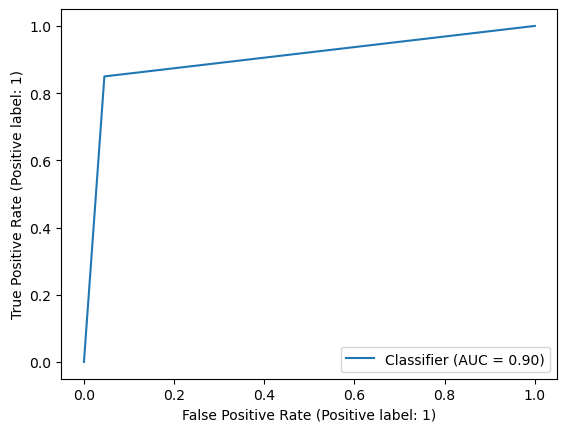

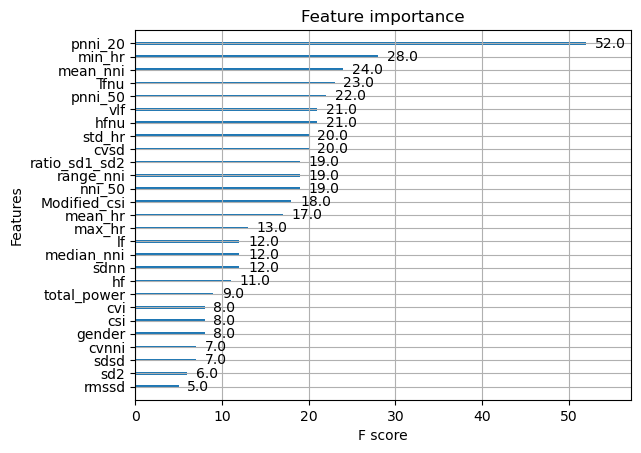

In [81]:
y_pred_train = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_all.best_estimator_)
plt.show()